In [2]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [3]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
print(f"length of the text file = {len(text)}")

length of the text file = 1115394


In [5]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [6]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [7]:
stoi = {s:i for i, s in enumerate(chars)}
itos = {i:s for s, i in stoi.items()} 
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

In [8]:
print(encode('hi there'))
print(decode(encode('hi there')))

[46, 47, 1, 58, 46, 43, 56, 43]
hi there


In [9]:
import torch 
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:100])

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59])


In [10]:
n = int(len(data) * 0.9) 
train_data = data[:n]
val_data = data[n:]

In [11]:
block_size = 8 
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [12]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"input: {context} ---> target: {target}")

input: tensor([18]) ---> target: 47
input: tensor([18, 47]) ---> target: 56
input: tensor([18, 47, 56]) ---> target: 57
input: tensor([18, 47, 56, 57]) ---> target: 58
input: tensor([18, 47, 56, 57, 58]) ---> target: 1
input: tensor([18, 47, 56, 57, 58,  1]) ---> target: 15
input: tensor([18, 47, 56, 57, 58,  1, 15]) ---> target: 47
input: tensor([18, 47, 56, 57, 58,  1, 15, 47]) ---> target: 58


In [13]:
torch.manual_seed(1337)
batch_size = 4 # how many examples to put into the model in parellel 
block_size = 8 # the maximum context length to predict the next token  

def get_batch(split):
    data = train_data if split=='train' else val_data 
    ix = torch.randint(len(data) - block_size, (batch_size, ))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y 

xb, yb = get_batch('train')
print('inputs')
print(xb)
print(f'shape = {xb.shape}')
print('outputs')
print(yb)
print(f'shape = {yb.shape}')
print('----------------------------')

for bi in range(batch_size):
    for ti in range(block_size):
        context = xb[bi, :ti+1]
        target = yb[bi, ti]
        print(f"inputs: {context} --> target: {target}")

inputs
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
shape = torch.Size([4, 8])
outputs
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
shape = torch.Size([4, 8])
----------------------------
inputs: tensor([24]) --> target: 43
inputs: tensor([24, 43]) --> target: 58
inputs: tensor([24, 43, 58]) --> target: 5
inputs: tensor([24, 43, 58,  5]) --> target: 57
inputs: tensor([24, 43, 58,  5, 57]) --> target: 1
inputs: tensor([24, 43, 58,  5, 57,  1]) --> target: 46
inputs: tensor([24, 43, 58,  5, 57,  1, 46]) --> target: 43
inputs: tensor([24, 43, 58,  5, 57,  1, 46, 43]) --> target: 39
inputs: tensor([44]) --> target: 53
inputs: tensor([44, 53]) --> target: 56
inputs: tensor([44, 53, 56]) --> target: 1
inputs: tensor([44, 53, 56,  1]) --> target: 58

In [14]:
ix = torch.randint(len(data) - block_size, (batch_size, ))
x = torch.stack([data[i:i+block_size] for i in ix])
y = torch.stack([data[i+1:i+block_size+1] for i in ix])
print(ix)
print(x)
print(y)

tensor([1081275,  241627,  748567,  905830])
tensor([[53, 59, 56,  0, 41, 39, 40, 47],
        [63, 53, 59,  1, 39, 50, 50,  6],
        [ 0, 24, 17, 27, 26, 32, 17, 31],
        [ 1, 39, 52, 42,  1, 59, 52, 56]])
tensor([[59, 56,  0, 41, 39, 40, 47, 52],
        [53, 59,  1, 39, 50, 50,  6,  1],
        [24, 17, 27, 26, 32, 17, 31, 10],
        [39, 52, 42,  1, 59, 52, 56, 59]])


In [15]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
torch.manual_seed(2024)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None): # targets = (B, T)
        logits = self.token_embedding_table(idx) # idx = (B, T)

        if targets is None:
            loss = None 
        else:
            B, T, C = logits.shape 
            logits = logits.view(B*T, C) 
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss  

    def generate(self, idx, max_new_tokens):
        for i in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :] # (B, C) 
            probs = F.softmax(logits, -1) # (B, C)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx  

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

print(decode(m.generate(idx=torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))

torch.Size([32, 65])
tensor(4.4547, grad_fn=<NllLossBackward0>)

Yr.YjvmHFQqBWq$?lP$PbdNM.
IT:aT:XAFhQMX:WMlcvTqeVtA:$?whM&KAXBk$JBh,zo!-fHP?$quhdMrn yNx-Vi3rXf?:Hxw


In [16]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [17]:
print(sum([p.nelement() for p in m.parameters()]))

4225


In [18]:
batch_size = 32 

for steps in range(10000):
    xb, yb = get_batch('train')

    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step() 

print(loss.item())

2.606048822402954


In [19]:
print(decode(m.generate(idx=torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


Tho worise s see yo cksid; wo hailthasth; laveeng o lde myxtite otowint:
H:
I'de weso t:
Paneel' thanonnrs at an ndicl ts,
K:

IOUCEd

Thayorat, gh t s?
Magr's tine I we
LAUSon ostheldoul s foprcks tok t ce.
bive
Gosun d tangeithane ais:
s, s bras me!jeseacouloust Moucowin;
AUEO areondengind hoteerchoy'lthyo:
Munglun wonFRI h lcothy senawisubrs orangacongle quiond elofeprst;es waisharane, geear: indol fr wes cthin!of unesof fede int llyathathaderambures.

Th r;
Thetoun kesteroise--the.
ce r vero


In [20]:
# aggregated weighted sum (toy example)
# b = weight 
# a = data 
# c = weighted sum 
torch.manual_seed(42)
a = torch.tril(torch.ones(3,3))
a /= a.sum(1, keepdim=True)
b = torch.randint(0, 10, (3, 2)).float()
c = a @ b
print(f'a = {a}') # (T, T)
print(f'b = {b}') # (T, C)
print(f'c = {c}') # (T, C) 

a = tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
b = tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
c = tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [21]:
# toy example with Batch dimension with different approach 
B, T, C = 4, 8, 2
x = torch.randn((B, T, C))

In [27]:
# %%timeit -r 10 -n 100
# 1) first approach. Use tril and sum/div. 
weight = torch.tril(torch.ones(T, T))
weight /= weight.sum(1, keepdim=True)
xbow = weight @ x # (T, T) @ (B, T, C) = (B, T, T) @ (B, T, C) = (B, T, C)

In [28]:
# %%timeit -r 10 -n 100
# 2) second approach. Use mean(). 
xbow2 = torch.zeros((B, T, C))
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1] # (T, C)
        xbow2[b, t] = torch.mean(xprev, 0)

In [29]:
# %%timeit -r 10 -n 100
# 3) third approach. Use softmax(). 
weight = torch.tril(torch.ones(T, T))
weight = weight.masked_fill(weight == 0, float('-inf'))
weight = F.softmax(weight, -1)
xbow3 = weight @ x 

In [30]:
# All three approaches result in the same values 
torch.allclose(xbow, xbow2) and torch.allclose(xbow2, xbow3)

True

In [31]:
# Self Attention! 
B, T, C = 4, 8, 32 
x = torch.randn((B, T, C))

# single-head attention
head_size = 16 
query = nn.Linear(C, head_size, bias=False) 
key = nn.Linear(C, head_size, bias=False) 

q = query(x) # (B, T, H)
k = key(x) # (B, T, H)

weight = q @ k.transpose(-2, -1) # (B, T, H) @ (B, H, T) = (B, T, T) 
tril = torch.tril(torch.ones(T, T))
weight = weight.masked_fill(tril == 0, float('-inf')) # For auto-regressive GPT-like training! 
weight = F.softmax(weight, -1)
print('weight shape = ', weight.shape)

value = nn.Linear(C, head_size, bias=False) # head_size can be a different value here. 
v = value(x)
out = weight @ v # (B, T, T) @ (B, T, H) = (B, T, H) 
print(out.shape)

weight shape =  torch.Size([4, 8, 8])
torch.Size([4, 8, 16])


In [32]:
weight[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4440, 0.5560, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6077, 0.1436, 0.2486, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6923, 0.0735, 0.1939, 0.0402, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0145, 0.4412, 0.0338, 0.0810, 0.4295, 0.0000, 0.0000, 0.0000],
        [0.0067, 0.2234, 0.0057, 0.1571, 0.2429, 0.3642, 0.0000, 0.0000],
        [0.0345, 0.0742, 0.2101, 0.1547, 0.0904, 0.1394, 0.2967, 0.0000],
        [0.0292, 0.1079, 0.0058, 0.0370, 0.1783, 0.0222, 0.0166, 0.6029]],
       grad_fn=<SelectBackward0>)

Notes:
Attention is a communication mechanism. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
Each example across batch dimension is of course processed completely independently and never "talk" to each other
In an "encoder" attention block just delete the single line that does masking with tril, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
"self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
"Scaled" attention additional divides wei by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

In [33]:
# Scaled self-attention! 
q = torch.randn((B, T, head_size))
k = torch.randn((B, T, head_size))
weight = q @ k.transpose(-2, -1) * head_size ** -0.5 
print(q.var())
print(k.var())
print(weight.var())

tensor(1.0116)
tensor(0.9358)
tensor(0.8944)


In [34]:
# Why unit variance? 
low_var = F.softmax(torch.tensor([1.0, -5.0, -2.0, 2.0, 5.0]), -1)
high_var = F.softmax(torch.tensor([1.0, -5.0, -2.0, 2.0, 5.0]) * 10, -1)
print(low_var)
print(high_var) # too peaky --> converges to one-hot --> less meaningful training

tensor([1.7132e-02, 4.2467e-05, 8.5298e-04, 4.6571e-02, 9.3540e-01])
tensor([4.2484e-18, 3.7835e-44, 3.9754e-31, 9.3576e-14, 1.0000e+00])


In [37]:
class LayerNorm1d:

    def __init__(self, dim, eps=1e-5):
        self.eps = eps 
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

    def __call__(self, x):
        xmean = x.mean(dim=1, keepdim=True) # dim=1 is layer dimension. (Not batch dimension) 
        xvar = x.var(dim=1, keepdim=True)
        xhat = (x - xmean) / (torch.sqrt(xvar) + self.eps) # nomalize to unit var 
        self.out = xhat * self.gamma + self.beta 
        return self.out 

    def parameters():
        return [self.gamma, self.beta]

module = LayerNorm1d(100)
x = torch.randn(32, 100)
x = module(x)
print(x.shape)

torch.Size([32, 100])


In [42]:
# check mean,std of output of layer normalization at initalization(mean=0, var=1)  
print(x[:, 0].mean(), x[:, 0].std()) # mean,std across batch inputs
print(x[0, :].mean(), x[0, :].std()) # mean,std of features of a single input from batch 

tensor(-0.1025) tensor(1.0664)
tensor(-9.5367e-09) tensor(1.0000)


In [43]:
# French to English translation example:

# <--------- ENCODE ------------------><--------------- DECODE ----------------->
# les réseaux de neurones sont géniaux! <START> neural networks are awesome!<END>


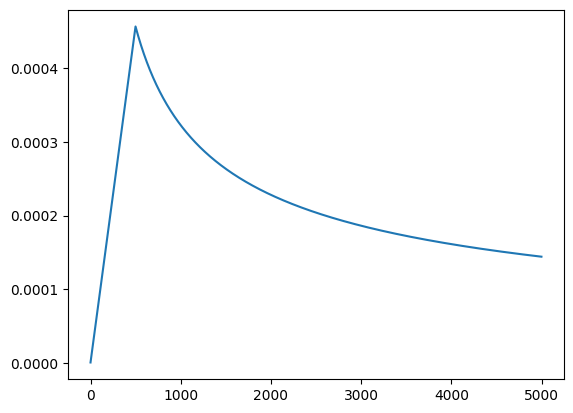

In [54]:
# learning rate scheduler 

# Attention is all you need - style schedule 
# d−0.5 ·min(step_num−0.5,step_num·warmup_steps−1.5)

d = 384 
step_num = 5000
warmup_steps = 500 

lr = [0.2 * d**-0.5 * min(s**-0.5, s * warmup_steps**-1.5) for s in range(1, step_num+1)]

from matplotlib import pyplot as plt 
plt.plot(range(step_num), lr)

In [56]:
print(x)
print(y)

tensor([[-0.4966, -0.9165, -2.0767,  ..., -2.6402,  0.3062,  0.1914],
        [ 0.5601,  0.4970, -1.4433,  ...,  0.4530,  1.1097,  0.2261],
        [-0.4522,  0.0361, -1.1335,  ...,  3.0654, -0.7695, -0.5377],
        ...,
        [-2.5013,  0.7146, -0.3965,  ...,  0.0191,  1.0317, -0.6667],
        [-1.9306,  0.0766, -0.0589,  ...,  1.6301, -0.0671,  0.8537],
        [ 1.2032,  0.1769, -1.8446,  ...,  1.6989, -0.5776,  1.1134]])
tensor([[59, 56,  0, 41, 39, 40, 47, 52],
        [53, 59,  1, 39, 50, 50,  6,  1],
        [24, 17, 27, 26, 32, 17, 31, 10],
        [39, 52, 42,  1, 59, 52, 56, 59]])


In [84]:
# label smoothing 
B, T = y.shape 
smoothing = 0.1 
soft_y = torch.full(size=(B * block_size, vocab_size), fill_value=smoothing / (vocab_size-1))
tmp_y = y.view(B * block_size).unsqueeze(1)
soft_y.scatter_(1, tmp_y, 1.0 - smoothing)
loss_ = F.cross_entropy(soft_y, soft_y, reduction='mean')
y_ = y.view(B * block_size)
for b in range(B):
    print(torch.allclose(soft_y[b, y_[b]], torch.tensor(1.0 - smoothing)))

True
True
True
True
